# Test different metrics of surprise for framework paper

### set a measure of potential for inputs
 - for each road segment that is blocked calculate the potential as the capacity (lanes * speed)

In [589]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import json
import xml.etree.ElementTree as ET
import numpy as np

In [590]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [591]:
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
#dbFile = 'lhc_samples/fleet_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'
comb_scenarios = {}


In [592]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            comb_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            comb_scenarios.update(result)    

print(len(comb_scenarios))

Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
2000


In [593]:
### join 3 sqlite database files
#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
#dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
#dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'

#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
dbFiles = [dbFile2, dbFile3]
comb_scenarios = {}
scenCount = 0
for dbFile in dbFiles:
    with ThreadPoolExecutor(max_workers=6) as executor:
        ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
        if 'fleet' in dbFile:
            for result in executor.map(read_fleet_from_db, queries):
                comb_scenarios.update(result)        
        else:
            for result in executor.map(read_ladris_from_db, queries):
                for key, value in result.items():
                    if key in comb_scenarios:
                        new_key = scenCount + int(key)
                        scenCount += 1
                        comb_scenarios[new_key] = value
                    else:
                        comb_scenarios[key] = value 
print(len(comb_scenarios))

Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  292
Length of rows:  2000
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
3896


# Get Ladris Roads
- Potential is measured as Lanes * Speed * Length

In [594]:
roadFile = '../lhc_samples/data/ladris/C27F9DE4CE6780696685FB4A4E31E242_orig'
with open(roadFile, 'r') as f:
    data = json.load(f)

ladris_latlong_dict = {}
ladris_potential_dict = {}
modified_dict = {}

for i in data:
    #print(i)
    ladris_latlong_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = i['geometry']
    lanes = i['num_lanes']
    speed = i['speed_mph']
    ### convert speed to m/s
    speed = speed * 0.44704
    length = i['length_meters']
    ladris_potential_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = lanes * speed# * length

# !!!Length seems to give extra potential to low potential roads!!!!

In [595]:
ladris_potential_dict[335090]

21.45792

# Get Fleet Roads

In [596]:
### read segment id's from ../lhc_samples/data/fleet/segments.xml
tree = ET.parse('../lhc_samples/data/fleet/segments.xml')
root = tree.getroot()

fleet_segment_dict = {}
fleet_potential_dict = {}
for child in root:
    fleet_segment_dict[child.find('ID').text] = child.find('Link_ID').text
    lanes = int(child.find('Number_of_Lanes').text)
    speed = int(child.find('Freeflow_Speed').text)
    fleet_potential_dict[child.find('ID').text] = lanes * speed

### read ../lhcsamples/data/fleet/links.xml
tree = ET.parse('../lhc_samples/data/fleet/links.xml')
root = tree.getroot()

fleet_link_dict = {}
fleet_name_dict = {}
for child in root:
    fleet_link_dict[child.find('ID').text] = [child.find('ANode').text, child.find('BNode').text]    
    fleet_name_dict[child.find('ID').text] = child.find('Name').text

### read ../lhcsamples/data/fleet/nodes.xml and get lat long for BNode of each fleet_link_dict
tree = ET.parse('../lhc_samples/data/fleet/nodes.xml')
root = tree.getroot()

fleet_node_dict = {}
for child in root:
    fleet_node_dict[child.find('ID').text] = [child.find('Latitude').text, child.find('Longitude').text]

fleet_lat_long_dict = {}
### for each segment in fleet_segment_dict, get the link_id, from fleet_link_dict get the BNode, from fleet_node_dict get the lat long
for segment in fleet_segment_dict:
    link_id = fleet_segment_dict[segment]
    anode = fleet_link_dict[link_id][0]
    bnode = fleet_link_dict[link_id][1]
    lat_long = [fleet_node_dict[anode], fleet_node_dict[bnode]]
    fleet_lat_long_dict[int(segment)] = [[float(lat_long[0][1]), float(lat_long[0][0])],[float(lat_long[1][1]), float(lat_long[1][0])]]

In [597]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [598]:
if 'ladris' in dbFile:
    df_results['minutes'] = df_results[0] * 60
    df_results['hours'] = df_results[0]
else:
    ### create a new column for the df_results called minutes that is equal to df_results[0] / 60
    df_results['minutes'] = df_results[0] / 60
    ### create a new column for df_results called hours that is equal to df_results[0] / 3600
    df_results['hours'] = df_results[0] / 3600

df_results.describe()

,0,minutes,hours
count,3896.000000,3896.000000,3896.000000
mean,12577.284394,209.621407,3.493690
std,3661.927762,61.032129,1.017202
min,9600.000000,160.000000,2.666667
25%,9600.000000,160.000000,2.666667
50%,12900.000000,215.000000,3.583333
75%,13200.000000,220.000000,3.666667
max,30000.000000,500.000000,8.333333


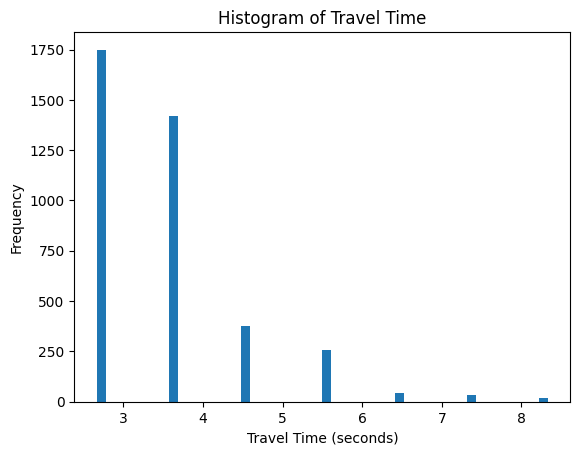

In [599]:
### Plot histogram of df_results
import matplotlib.pyplot as plt
plt.hist(df_results['hours'], bins=50)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()

In [600]:
df_results['hours']

0       2.666667
1       4.583333
2       3.666667
3       3.666667
4       3.583333
          ...   
3891    3.583333
3892    2.666667
3893    3.666667
3894    3.666667
3895    3.583333
Name: hours, Length: 3896, dtype: float64

In [601]:

### get indexs of df_results for df_results['hours'] >= 6.5
idx = df_results[df_results['hours'] >= 4].index
### get indexs of df_results for df_results['hours'] < 6.5
idx2 = df_results[df_results['hours'] < 4].index

### describe df_results for the indexs of idx
df_results.loc[idx].describe()

,0,minutes,hours
count,727.000000,727.000000,727.000000
mean,18884.319120,314.738652,5.245644
std,3222.916659,53.715278,0.895255
min,16200.000000,270.000000,4.500000
25%,16500.000000,275.000000,4.583333
50%,16500.000000,275.000000,4.583333
75%,19800.000000,330.000000,5.500000
max,30000.000000,500.000000,8.333333


In [602]:
experiments = df
lowExperiments = experiments.loc[idx2]
highExperiments = experiments.loc[idx]
### Create outcomes as an array of df_results
outcomes = list(df_results['hours'].values)
lowOutcomes = list(df_results.loc[idx2]['hours'].values)
highOutcomes = list(df_results.loc[idx]['hours'].values)

In [603]:
### describe highOutcomes
pd.Series(highOutcomes).describe()

count    727.000000
mean       5.245644
std        0.895255
min        4.500000
25%        4.583333
50%        4.583333
75%        5.500000
max        8.333333
dtype: float64

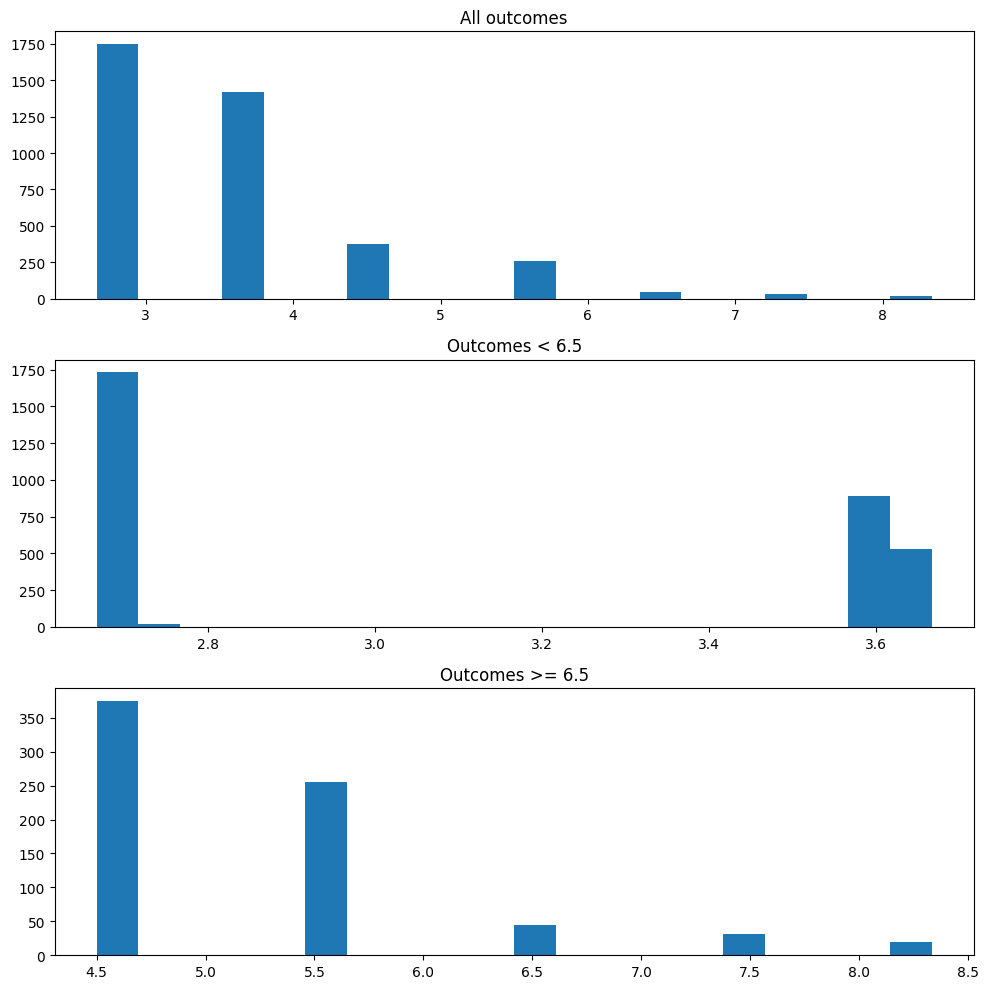

In [604]:
import matplotlib.pyplot as plt

### create three subplots of the outcomes
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(outcomes, bins=20)
ax[0].set_title('All outcomes')
ax[1].hist(lowOutcomes, bins=20)
ax[1].set_title('Outcomes < 6.5')
ax[2].hist(highOutcomes, bins=20)
ax[2].set_title('Outcomes >= 6.5')
plt.tight_layout()
plt.show()


# The list of segments that are associated with High critical evacuation times and are low on potential 0.5 lam1, 1.0 lam2
## Ladris Critical Segments
![image.png](images/ladris_critical_segments_2025-05-23.png)
## Ladris Critical and Low Potential (CSI)
![image.png](images/ladris_CSI_segments_2025-05-28.png)
## Fleet Critical Segments
![image.png](images/fleet_critical_segments.png)
## Fleet Critical and Low Potential (CSI)
![image-2.png](images/fleet_CSI_segments.png)



# Custom surprising critical measure
$$
Z=λ_1 × EvacuationTime − λ_2 × ScenarioPotential
$$
- Evacuation time is time 90% of population reaches destination
- Scenario Potential is the total potential measure of closed segments for that scenario

In [605]:
### create a new dataframe from df where each column is multiplied by the corresponding value in ladris_potential_dict
ladris_potential_df = df.copy()
for i in ladris_potential_dict:
    if i in ladris_potential_df.columns:
        ladris_potential_df[i] = ladris_potential_df[i] * ladris_potential_dict[i]

ladris_potential_df.head()

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,703766232,105574067,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,0,0,1,...,1,1,1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,1,1,1,...,1,0,0,1,1,1,1,1,0,0
3,1,0,1,0,1,0,1,0,1,1,...,1,1,0,1,1,1,0,0,1,0
4,0,0,1,1,1,1,1,0,1,0,...,1,1,0,0,1,1,0,0,0,0


In [606]:
### print the columns that are greater than 0 for ladris_potential_df.iloc[1]
print(ladris_potential_df.iloc[1][ladris_potential_df.iloc[1] > 0])




10091169783    1
949301691      1
10949397063    1
711443713      1
11156823230    1
1172855239     1
1173061709     1
91170204       1
91169787       1
10105575029    1
91170209       1
10091170129    1
1175163236     1
711209710      1
10112051514    1
11173061942    1
10116945306    1
10091170208    1
10949290445    1
703766232      1
105574067      1
949536370      1
Name: 1, dtype: int64


In [607]:
### add a new column to ladris_potential_df that is the sum of all the columns
ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)

### create a new column in ladris_potential_df called 'count' that is the count of columns that are greater than 0
ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)

ladris_potential_df

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587,sum,count
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,18,19
1,1,1,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,22,23
2,1,0,0,1,0,0,0,1,1,1,...,0,1,1,1,1,1,0,0,17,18
3,1,0,1,0,1,0,1,0,1,1,...,0,1,1,1,0,0,1,0,17,18
4,0,0,1,1,1,1,1,0,1,0,...,0,0,1,1,0,0,0,0,16,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5,6
3892,1,1,0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,7,8
3893,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,6,7
3894,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,5,6


In [608]:
lam1 = 0.75
lam2 = 1

### create x as a normalized measure of df_results['hours'] to be values between 0 and 1
normEvac = (df_results['hours'] - df_results['hours'].min()) / (df_results['hours'].max() - df_results['hours'].min())

### creaet normPot as a normalized measure of ladris_potential_df['sum'] to be values between 0 and 1
normPot = (ladris_potential_df['sum'] - ladris_potential_df['sum'].min()) / (ladris_potential_df['sum'].max() - ladris_potential_df['sum'].min())

df_results['z'] = lam1*normEvac - lam2*normPot + lam2

df_results.head()


,0,minutes,hours,z
0,9600,160.0,2.666667,0.333333
1,16500,275.0,4.583333,0.438862
2,13200,220.0,3.666667,0.502723
3,13200,220.0,3.666667,0.502723
4,12900,215.0,3.583333,0.528731


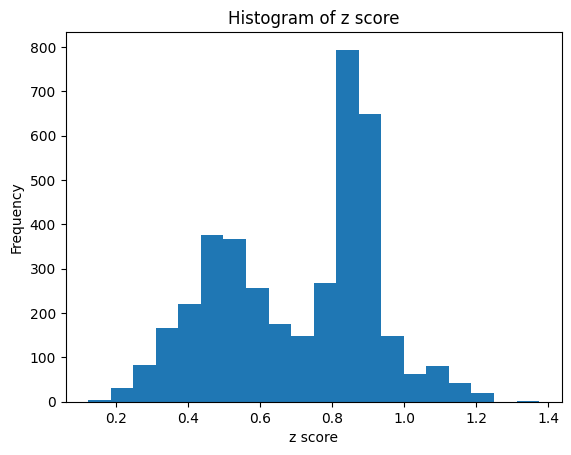

In [609]:
### Plot histogram of df_results['z']
plt.hist(df_results['z'], bins=20)
plt.xlabel('z score')
plt.ylabel('Frequency')
plt.title('Histogram of z score')
plt.show()

In [610]:
df_results['z'].describe()

count    3896.000000
mean        0.707185
std         0.219163
min         0.122141
25%         0.512936
50%         0.777778
75%         0.888889
max         1.375000
Name: z, dtype: float64

In [611]:
df.describe()

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,703766232,105574067,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587
count,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,...,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000
mean,0.500513,0.501283,0.245893,0.242556,0.243840,0.501797,0.242556,0.500000,0.500770,0.244353,...,0.246150,0.243840,0.498973,0.242813,0.244097,0.245380,0.244610,0.243070,0.243326,0.244610
std,0.500064,0.500063,0.430671,0.428684,0.429452,0.500061,0.428684,0.500064,0.500064,0.429758,...,0.430822,0.429452,0.500063,0.428838,0.429605,0.430367,0.429911,0.428992,0.429146,0.429911
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [612]:
import prim

# Perform Prim Analysis on df_results and df based on maximizing critical (hours)

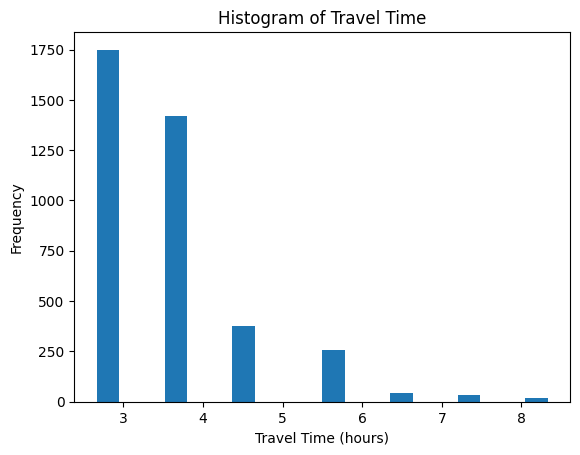

In [613]:
### plot histogram of df_results['hours']
plt.hist(df_results['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()


# TODO: Establish automated way to identify otimum threshold for the PRIM analysis
- start with mean
- perform prim and measure number of inputs 
- iterate through increasing thershold values
- determine the threshold with the largest number of inputs for scenario discovery

In [614]:
### get the index values of df_results.loc[lp_evac_idx]['hours] that are greater than 4
#mask = df_results.loc[lp_evac_idx]['hours'] > 4
### get the index of df_results where df_results['hours'] > 4
critical_fleet_results_idx = df_results[df_results['hours'] > 4].index

### describe df_results.loc[critical_fleet_results_idx]
df_results.loc[critical_fleet_results_idx].describe()
critical_results_describe = df_results.loc[critical_fleet_results_idx].describe().to_dict()
np.floor(critical_results_describe['hours']['mean'])

5.0

In [615]:
setMean = critical_results_describe['hours']['mean']
setMax = critical_results_describe['hours']['max']

crit_boxes = []

### create 10 threshold values from setMean to setMax in increments of 0.5
thresholds = []
differ_increment = (setMax - setMean)/10
for i in range(10):
    if i == 0:
        thresholds.append(setMean)
    else:
        thresholds.append(thresholds[i-1] + differ_increment)

maxThreshold = 0
maxCount = 0
critIndex = 0
### create a loop to iterate from setMean to setMax in increments of 0.5
for t in thresholds:        
    prim_alg = prim.Prim(df.loc[critical_fleet_results_idx], df_results.loc[critical_fleet_results_idx]['hours'], threshold=t, threshold_type='>')
    try:
        crit_box = prim_alg.find_all()
        #print(len(crit_box))

        crit_boxes.append(crit_box)
        
        ### get list of all index values for each crit_box
        crit_ids = []
        for i in range(len(crit_box)):
            print(list(crit_box[i].limits.index))
            ### add crit_box[i].limits.index to crit_ids but only if it is not already in crit_ids
            for j in list(crit_box[i].limits.index):
                if j not in crit_ids:
                    crit_ids.append(j)

        ### print the number of unique index values in crit_ids
        if len(set(crit_ids)) >= maxCount:
            maxCount = len(set(crit_ids))
            maxThreshold = t
            critIndex = thresholds.index(t)
        print('Number of unique index values in crit_ids: ', t, len(set(crit_ids)))
    except:
        print("zero boxes")
        print('Number of unique index values in crit_ids: ', t, len(set(crit_ids)))

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10946271023', '10116970483', '91170204', '10091170129', '1175163236', '10116945306', '91170034']
['10116970483', '1173061709', '10091170129', '10112051514', '10116945306']
['10116970483', '1173061709', '10091170129', '10091169790']
['10116952815', '10116970483', '91169787', '10105575029', '10116945306', '10091170208', '703766232', '105574067']
['10116970483', '10091170129', '10116945306', '949536370']
['10116970483', '91170209', '10091170129']
['10105537445', '10091170208']
['10116945306']
[]
Number of unique index values in crit_ids:  5.245644199908299 19


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '10091170129', '10112051514', '949536370', '10091169790']
['10116970483', '10091170129', '10091170208', '10091169790', '10710783587']
['10116970483', '1173061709', '10091170129', '10949290445']
['10116970483', '1173061709', '10091170129', '10710783587']
['10116970483', '1172855239', '10091170129']
[]
Number of unique index values in crit_ids:  5.554413113250803 10


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '10091170129', '10112051514', '949536370', '10091169790']
['10116970483', '10091170129', '10091170208', '10091169790', '10710783587']
['10116970483', '1173061709', '10091170129', '10949290445']
['10116970483', '1173061709', '10091170129', '10710783587']
['10116970483', '1172855239', '10091170129']
[]
Number of unique index values in crit_ids:  5.863182026593306 10


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '10091170129', '10112051514', '949536370', '10091169790']
['10116970483', '10091170129', '10091170208', '10091169790', '10710783587']
['10116970483', '1173061709', '10091170129', '10949290445']
['10116970483', '1173061709', '10091170129', '10710783587']
['10116970483', '1172855239', '10091170129']
[]
Number of unique index values in crit_ids:  6.17195093993581 10


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '91170204', '10091170129', '949536370', '10091169790']
['10116970483', '10091170129', '10091170208', '949536370']
['10116970483', '1173061709', '10091170129', '10091169790']
['11156823230', '1173061709', '10091170129', '10091170208']
['10116952815', '10105575029']
[]
Number of unique index values in crit_ids:  6.4807198532783135 10


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '1173061709', '10091170129', '711209710', '949536370']
['10116970483', '1173061709', '91170204', '711209710', '949536370']
['91169787', '711209710', '949536370']
['11173061942', '10710783587']
[]
Number of unique index values in crit_ids:  6.789488766620817 9


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '1173061709', '10091170129', '711209710', '949536370']
['10116970483', '1173061709', '91170204', '711209710', '949536370']
['91169787', '711209710', '949536370']
['11173061942', '10710783587']
[]
Number of unique index values in crit_ids:  7.098257679963321 9


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '1173061709', '10091170129', '711209710', '949536370']
['10116970483', '1173061709', '91170204', '711209710', '949536370']
['91169787', '711209710', '949536370']
['11173061942', '10710783587']
[]
Number of unique index values in crit_ids:  7.407026593305824 9
['10116970483', '1173061709', '949536370', '10091169790', '10710783587']
[]
Number of unique index values in crit_ids:  7.715795506648328 5
['10116970483', '1173061709', '949536370', '10091169790', '10710783587']
[]
Number of unique index values in crit_ids:  8.024564419990831 5


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


In [616]:
print('Max Count: ', maxCount)
print('Max Threshold: ', maxThreshold)
crit_boxes[critIndex][0].limits

crit_ids = []
for i in range(len(crit_boxes[critIndex])):
    print(list(crit_boxes[critIndex][i].limits.index))
    ### add crit_box[i].limits.index to crit_ids but only if it is not already in crit_ids
    for j in list(crit_boxes[critIndex][i].limits.index):
        if j not in crit_ids:
            crit_ids.append(j)

Max Count:  19
Max Threshold:  5.245644199908299
['10946271023', '10116970483', '91170204', '10091170129', '1175163236', '10116945306', '91170034']
['10116970483', '1173061709', '10091170129', '10112051514', '10116945306']
['10116970483', '1173061709', '10091170129', '10091169790']
['10116952815', '10116970483', '91169787', '10105575029', '10116945306', '10091170208', '703766232', '105574067']
['10116970483', '10091170129', '10116945306', '949536370']
['10116970483', '91170209', '10091170129']
['10105537445', '10091170208']
['10116945306']
[]


# Perform Prim Analysis on df_results and df based on maximizing z


In [617]:
df_results['z'].describe()

count    3896.000000
mean        0.707185
std         0.219163
min         0.122141
25%         0.512936
50%         0.777778
75%         0.888889
max         1.375000
Name: z, dtype: float64

In [618]:
### Get the index of rows in df_results['z'] that are greater than 0.1
idx = df_results[df_results['z'] > 0.75].index
### print the rows of df where the index is in idx
#df.loc[idx].describe()
df_results.loc[idx]['z'].describe()
CSI_results_describe = df_results.loc[idx]['z'].describe().to_dict()
print(CSI_results_describe['mean'])

0.8881489217111954


In [619]:
setMean = CSI_results_describe['mean']
setMax = CSI_results_describe['max']

csi_boxes = []

### create 10 threshold values from setMean to setMax in increments of 0.5
thresholds = []
differ_increment = (setMax - setMean)/10
for i in range(10):
    if i == 0:
        thresholds.append(setMean)
    else:
        thresholds.append(thresholds[i-1] + differ_increment)

maxThreshold = 0
maxCount = 0
csi_index = 0
### create a loop to iterate from setMean to setMax in increments of 0.5
for t in thresholds: 
    prim_alg = prim.Prim(df.loc[idx], df_results.loc[idx]['z'], threshold=t, threshold_type='>')
    try:
        CSI_box = prim_alg.find_all()
        #print(len(CSI_box))
        csi_boxes.append(CSI_box)

        csi_ids = []
        for i in range(len(CSI_box)):
            print(list(CSI_box[i].limits.index))
            ### add CSI_box[i].limits.index to csi_ids but only if it is not already in csi_ids
            for j in list(CSI_box[i].limits.index):            
                if j not in csi_ids:
                    csi_ids.append(j)
        ### print the number of unique index values in csi_ids
        if len(csi_ids) >= maxCount:
            maxCount = len(csi_ids)
            maxThreshold = t
            ### set csi_index to the index of t in thresholds
            csiIndex = thresholds.index(t)
        print('Number of unique index values in csi_ids: ', t, len(set(csi_ids)))
    except:
        print("found zero boxes")
        print('Number of unique index values in csi_ids: ', t, len(set(csi_ids)))

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['11173061942', '10091170208', '949536370', '105576314', '711443269']
['10091169783', '10105537445', '11173061942', '10116945306', '949536370', '711443269']
['949536370']
[]
Number of unique index values in csi_ids:  0.8881489217111954 8


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '1173061709', '91169787', '10116945306', '711443269', '91170034']
['10091169783', '1172855239', '91169787', '949536370', '105576314']
[]
Number of unique index values in csi_ids:  0.9368340295400759 10


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '1173061709', '10116945306', '105574067', '10708503028', '91170034']
[]
Number of unique index values in csi_ids:  0.9855191373689564 6


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['711443713', '10116970483', '1172855239', '1173061709', '1175163236', '10116945306', '10949290445', '91170034']
['10116970483', '1173061709', '10116945306']
[]
Number of unique index values in csi_ids:  1.0342042451978368 8


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10949397063', '10946271023', '10116970483', '1173061709', '711209710', '10116945306', '949536370']
[]
Number of unique index values in csi_ids:  1.0828893530267172 7


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10949397063', '10946271023', '10116970483', '1173061709', '711209710', '10116945306', '949536370']
['10091169783', '949301691', '10105537445', '1173061709']
['10091169783', '10105537445', '10091170129']
[]
Number of unique index values in csi_ids:  1.1315744608555975 11


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10116970483', '1173061709', '10116945306', '949536370']
['10091170129', '10112051514', '949536370']
[]
Number of unique index values in csi_ids:  1.180259568684478 6


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10091169783', '949301691', '10105537445', '10091170129']
[]
Number of unique index values in csi_ids:  1.2289446765133583 4


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['10091169783', '949301691', '10105537445', '10091170129']
[]
Number of unique index values in csi_ids:  1.2776297843422386 4
['10091169783', '949301691', '10105537445', '10091170129']
[]
Number of unique index values in csi_ids:  1.326314892171119 4


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


In [620]:
print('Max Count: ', maxCount)
print('Max Threshold: ', maxThreshold)
csi_boxes[csiIndex][1].limits

csi_ids = []
for i in range(len(csi_boxes[csiIndex])):
    print(list(csi_boxes[csiIndex][i].limits.index))
    ### add CSI_box[i].limits.index to csi_ids but only if it is not already in csi_ids
    for j in list(csi_boxes[csiIndex][i].limits.index):
        if j not in csi_ids:
            csi_ids.append(j)

Max Count:  11
Max Threshold:  1.1315744608555975
['10949397063', '10946271023', '10116970483', '1173061709', '711209710', '10116945306', '949536370']
['10091169783', '949301691', '10105537445', '1173061709']
['10091169783', '10105537445', '10091170129']
[]


# Generate KML for crit_box and CSI_box IDs


In [621]:
if 'fleet' in dbFile:
    print(fleet_lat_long_dict[int(crit_ids[0])])
else:
    print(ladris_latlong_dict[int(crit_ids[0])])

[[-121.0313, 39.2669], [-121.03304, 39.2667]]


In [622]:
import ast
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import LineString


In [623]:
if 'fleet' in dbFile:
    #### update fleet_lat_long_dict to be a dictionary of linestrings
    for i in fleet_lat_long_dict:
        fleet_lat_long_dict[i] = LineString([ast.literal_eval(str(fleet_lat_long_dict[i][0])), ast.literal_eval(str(fleet_lat_long_dict[i][1]))])
else:
    ### update ladris_latlong_dict to be a dictionary of linestrings
    for i in ladris_latlong_dict:
        ladris_latlong_dict[i] = LineString([ast.literal_eval(str(ladris_latlong_dict[i][0])), ast.literal_eval(str(ladris_latlong_dict[i][1]))])


In [624]:
if 'fleet' in dbFile:
    #all_gdf = GeoDataFrame(geometry=[fleet_lat_long_dict[i] for i in fleet_lat_long_dict])
    all_gdf = GeoDataFrame(
        {"id": list(fleet_lat_long_dict.keys()), "geometry": list(fleet_lat_long_dict.values())}
    )

    crit_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in crit_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in crit_ids]}
    )

    csi_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in csi_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in csi_ids]}
    )
else:
    all_gdf = GeoDataFrame(
        {"id": list(ladris_latlong_dict.keys()), "geometry": list(ladris_latlong_dict.values())}
    )

    crit_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in crit_ids], "geometry": [ladris_latlong_dict[int(i)] for i in crit_ids]}
    )

    csi_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in csi_ids], "geometry": [ladris_latlong_dict[int(i)] for i in csi_ids]}
    )


In [625]:
import datetime
now = datetime.datetime.now()
if 'fleet' in dbFile:
    crit_fname = 'fleet_crit_segments_'+str(now.date())+'.kml'
    csi_fname = 'fleet_csi_segments_'+str(now.date())+'.kml'
    ### output geodataframe sub_gdf to kml file where id is the identity label and geometry is the lat long for position of the segment
    crit_sub_gdf.to_file(crit_fname, driver='KML', index=False)
    csi_sub_gdf.to_file(csi_fname, driver='KML', index=False)
else:
    ### output geodataframe sub_gdf to kml file where id is the identity label and geometry is the lat long for position of the segment
    crit_fname = 'ladris_crit_segments_'+str(now.date())+'.kml'
    csi_fname = 'ladris_csi_segments_'+str(now.date())+'.kml'
    crit_sub_gdf.to_file(crit_fname, driver='KML', index=False)
    csi_sub_gdf.to_file(csi_fname, driver='KML', index=False)




/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Layer name 'fleet_crit_segments_2025-05-29' adjusted to 'fleet_crit_segments_2025_05_29' for XML validity.
  ogr_write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Layer name 'fleet_csi_segments_2025-05-29' adjusted to 'fleet_csi_segments_2025_05_29' for XML validity.
  ogr_write(


In [626]:
str(now.date())

'2025-05-29'

# Compare evac time for scenarios of CRIT and scenarios of CSI

In [627]:
print(len(crit_boxes[critIndex]), len(csi_boxes[critIndex]))


9 4


In [628]:
import prim as prim
import numpy as np


In [629]:
def getCriticalTimes(df, crit_box):
    criticalTimes = {}
    for c in range(len(crit_box)):
        ctime = []
        tempDict = {}

        ## the list of column names
        #list(crit_box[0].limits.index))

        ### the list of values
        #list(crit_box[0].limits['min'])
        cb_index = list(crit_box[c].limits.index)
        
        ### convert cb_index to integers
        if 'fleet' not in dbFile:
            for i in range(len(cb_index)):
                if isinstance(cb_index[i], str):
                    cb_index[i] = int(cb_index[i])

        ### create dictionary of list(crit_box[0].limits.index) and list(crit_box[0].limits['min'])
        for i in range(len(cb_index)):
            tempDict[cb_index[i]] = list(crit_box[c].limits['min'])[i]

        if len(tempDict) > 2:
            ### convert tempDict values to integers
            for i in tempDict:
                if isinstance(tempDict[i], str):
                    tempDict[i] = int(tempDict[i])
                else:
                    tempDict[i] = int(tempDict[i])
            #print(tempDict.values())

            ### get the index of df[list(crit_box[1].limits.index)] where the values are equal to tempDict.values()
            cb1_idx = list(df[cb_index].index)

            ### for each row of df[list(crit_box[1].limits.index)].values.tolist() compare the list to tempDict.values()
            count = 0
            for i in df[cb_index].values.tolist():
                if i == list(tempDict.values()):
                    #print(cb1_idx[count], i)
                    ctime.append(df_results.loc[cb1_idx[count]]['hours'])
                count += 1
            criticalTimes[c] = ctime
            print(round(np.mean(ctime), 2), round(np.max(ctime), 2), round(np.min(ctime), 2), len(ctime))
    return criticalTimes

# Results for Fleet 0.75 lam1, 1 lam2
### All Data
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 3.49 | 8.33 | 2.67 | 3896  |

### Critical
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 4.42 | 7.42 | 2.67 | 281   |
| 4.74 | 6.5  | 3.67 | 108   |
| 5.1  | 6.5  | 2.67 | 117   |
| 3.98 | 7.42 | 2.67 | 521   |
| 5.11 | 8.33 | 2.67 | 262   |
| 4.1  | 8.33 | 2.67 | 746   |

### CSI
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 4.97 | 5.5  | 3.58 | 148   |
| 3.78 | 8.33 | 2.67 | 242   |
| 3.19 | 5.5  | 2.67 | 481   |

# Results for Ladris 0.5 lam1, 1 lam2
- Reducing the crit lam1 to 0.1 reduced the mean eavacuation time of the CSI scenarios by 1 hour!
- increaseing the crit lam1 to 1 increases the mean evacuation time of the CSI scenarios by 1 hours!
  - doing this reduces several areas of surprise in particular the segments on lower colfax rd.
### All Data
| Mean | Max   | Min  | Count |
|------|-------|------|-------|
| 4.62 | 10.64 | 3.62 | 3980  |

### Critical
| Mean | Max   | Min  | Count |
|------|-------|------|-------|
| 8.04 | 10.55 | 5.17 | 114   |
| 6.56 | 10.64 | 4.13 | 242   |
| 6.23 | 10.55 | 4.11 | 508   |

### CSI
| Mean | Max   | Min  | Count |
|------|-------|------|-------|
| 5.63 | 10.51 | 4.19 | 175   |
| 6.44 | 10.51 | 4.45 | 145   |
| 5.58 | 10.29 | 4.19 | 317   |
| 5.62 | 10.51 | 3.95 | 605   |
| 4.52 | 10.21 | 3.65 | 503   |
| 4.38 | 9.46  | 3.65 | 321   |
| 4.33 | 8.38  | 3.67 | 494   |


In [630]:
len(crit_boxes[critIndex])

9

In [631]:
### get critical times for each crit_box
criticalTimes = getCriticalTimes(df, crit_boxes[critIndex])
#print(criticalTimes)
print("<><><><><><><><><><><><><><><><><>")
csiTimes = getCriticalTimes(df, csi_boxes[csiIndex])
print(len(criticalTimes), len(csiTimes))

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


4.42 7.42 2.67 281
4.74 6.5 3.67 108


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


5.1 6.5 2.67 117


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


3.98 7.42 2.67 521
5.11 8.33 2.67 262
4.1 8.33 2.67 746
<><><><><><><><><><><><><><><><><>
4.97 5.5 3.58 148
3.78 8.33 2.67 242


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


3.19 5.5 2.67 481
6 3


In [632]:
df_results['hours'].describe()

count    3896.000000
mean        3.493690
std         1.017202
min         2.666667
25%         2.666667
50%         3.583333
75%         3.666667
max         8.333333
Name: hours, dtype: float64

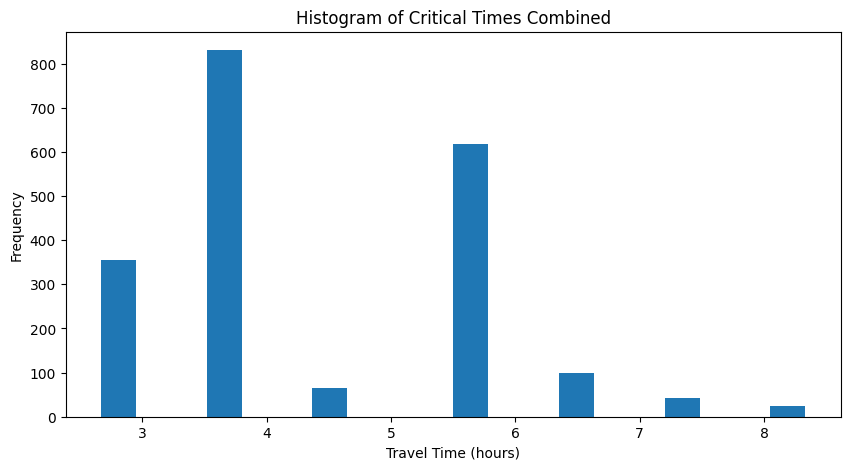

In [633]:
### create a histogram of the critical times combined
plt.figure(figsize=(10, 5))
plt.hist([item for sublist in criticalTimes.values() for item in sublist], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Critical Times Combined')
plt.show()

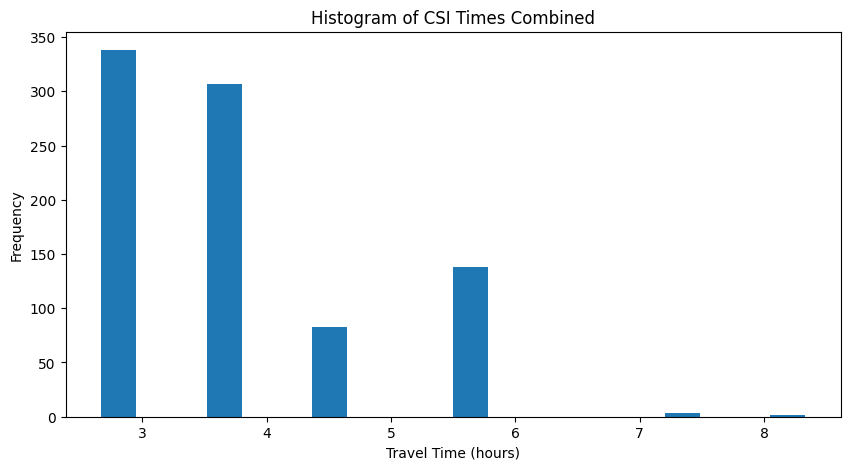

In [634]:
### create a histogram of csi times combined
plt.figure(figsize=(10, 5))
plt.hist([item for sublist in csiTimes.values() for item in sublist], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of CSI Times Combined')
plt.show()